In [467]:
import re
from importlib import reload
import glob
import sys
sys.path.insert(0, '../scripts/')
import get_bounding_boxes_from_html as bb
import seaborn as sns
here = os.getcwd()

wayback_scrape_dir = '../data/web.archive.org'
nyt_files = glob.glob(
    wayback_scrape_dir + '/web/*[!_]/nytimes.com/*'
)
nyt_files = sorted(nyt_files, key=lambda x: x.split('/')[-3])
bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
    nyt_files, here=here, headless=True
)

In [1908]:
mkdir cache/two-month-nyt-bounding-box-csvs/

In [1912]:
for bb_df in tqdm(bounding_box_dfs):
    key = bb_df.iloc[0]['key']
    bb_df.to_csv('cache/two-month-nyt-bounding-box-csvs/%s.csv' % key)

  0%|          | 0/2169 [00:00<?, ?it/s]

# Try to cluster and reason about homepages

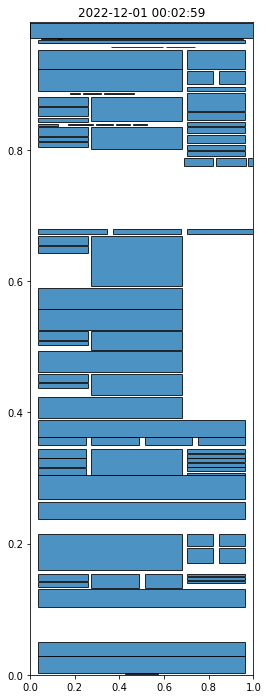

In [165]:
bb.plot_bounding_box_df(
    bb.normalize_x_y_height_width(bounding_box_dfs[0], round_val=3), 
    use_percs=True,
    figsize=(4, 12)
)

In [ ]:
coarse_grid = bb.make_coarsified_layout_grid(bounding_box_dfs[0], x_step=.005, y_step=.005)

ax = sns.heatmap(coarse_grid)
ymin, ymax = ax.get_ylim()
xmin, xmax = ax.get_xlim()

x_cutoff_pixel = bb.get_clip_size_grid(coarse_grid=coarse_grid, perc_intersections_cutoff=.05)
y_cutoff_pixel = bb.get_clip_size_grid(coarse_grid=coarse_grid, pos_col='y')
x_cutoff = list(coarse_grid.columns).index(x_cutoff_pixel)
y_cutoff = list(coarse_grid.index).index(y_cutoff_pixel)

ax.vlines(x_cutoff, ymin, ymax, colors='red', linewidth=1)
ax.hlines(y_cutoff, xmin, xmax, colors='red', linewidth=1)

In [454]:
x_cutoff = bb.get_clip_size_grid(bb_df=bounding_box_dfs[0], perc_intersections_cutoff=.05)
coarse_grid = bb.get_coarsified_layout_grid(bb_df=bounding_box_dfs[0], max_width=x_cutoff)

sns.heatmap(coarse_grid)

In [513]:
reload(bb)

<module 'get_bounding_boxes_from_html' from '/Users/spangher/Projects/usc-research/newsworthiness/notebooks/../scripts/get_bounding_boxes_from_html.py'>

In [514]:
bin_counts = []

for df in tqdm(bounding_box_dfs):
    c = bb.transform_input_for_clustering(
        df, use_x=True, use_width=True, use_height=False, use_y=False, 
        recalculate_page_width=True, x_clip_perc=.1
    )
    bin_counts.append(c)

  0%|          | 0/2169 [00:00<?, ?it/s]

In [574]:
coarse_grids = []
for df in tqdm(bounding_box_dfs):
    c = bb.get_coarsified_layout_grid(df, max_width=df.iloc[0]['page_width'], y_step=.01, x_step=.01)
    coarse_grids.append(c)

  0%|          | 0/2169 [00:00<?, ?it/s]

In [586]:
shapes = list(map(lambda df: df.shape, coarse_grids))
miny, minx= pd.DataFrame(shapes).min()
mod_coarse_grids = list(map(lambda df: df.iloc[:miny, :minx], coarse_grids))

In [629]:
grids_unstacked = np.vstack(list(map(lambda df: df.values.reshape(-1, miny*minx), mod_coarse_grids)))

<AxesSubplot:>

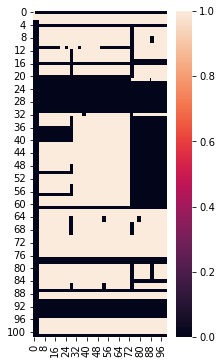

In [839]:
pca.fit(grids_unstacked)
pca_reduced = pca.transform(grids_unstacked)
approximation = pca.inverse_transform(pca_reduced)
_, ax = plt.subplots( figsize=(3, 6))
sns.heatmap(grids_unstacked[0].reshape(mod_coarse_grids[0].shape ))

<AxesSubplot:>

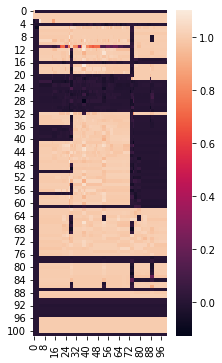

In [648]:
_, ax = plt.subplots( figsize=(3, 6))
sns.heatmap(approximation[0].reshape(mod_coarse_grids[0].shape), ax=ax)

<AxesSubplot:>

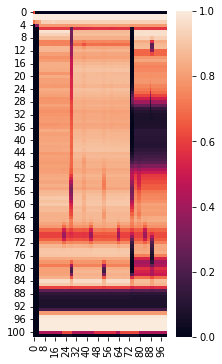

In [649]:
_, ax = plt.subplots( figsize=(3, 6))
sns.heatmap(sum(map(lambda x: x.values, mod_coarse_grids)) / len(mod_coarse_grids), ax=ax)

In [ ]:
# iteratively start from the top and match the 

In [516]:
from sklearn.cluster import AgglomerativeClustering

In [637]:
num_clusters = 3
clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(bin_counts)
# clustering = AgglomerativeClustering(n_clusters=num_clusters).fit(pca_reduced)

In [638]:
bbs_with_clusters = pd.Series(bounding_box_dfs).to_frame('dfs').assign(clusters=pd.Series(clustering.labels_))

In [639]:
import matplotlib.pyplot as plt 

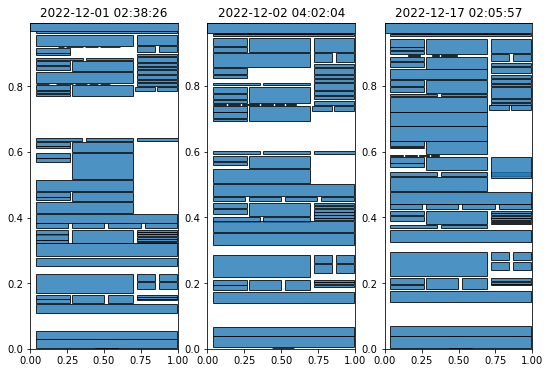

In [645]:
idx = 4

_, axarr = plt.subplots(1, num_clusters, figsize=(num_clusters * 3, 6 ))

for i in range(num_clusters):
    (bbs_with_clusters
     .loc[lambda df: df['clusters'] == i]['dfs']
     .pipe(lambda df: bb.plot_bounding_box_df(
         df.iloc[idx],
         use_percs=True,
         figsize=(3,6),
         round_val=3,
         ax=axarr[i]
     ))
    )

# Track article arcs

In [1238]:
all_bounding_box_df = pd.concat(bounding_box_dfs)
all_bounding_box_df = bb.restrict_to_wayback_urls_and_process(all_bounding_box_df)

<AxesSubplot:>

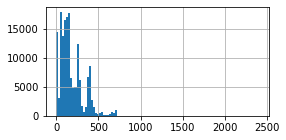

In [1111]:
all_bounding_box_df['height'].hist(bins=100, figsize=(4,2))

In [1112]:
from sklearn.neighbors import KernelDensity
import numpy as np
kde = KernelDensity(kernel='gaussian', bandwidth=20)

In [1120]:
# height of each box

In [1113]:
x = np.arange(0, 1000)
log_pdf = (kde
 .fit(all_bounding_box_df['height'].values.reshape(-1, 1))
 .score_samples(x.reshape(-1, 1))
)
pdf = np.exp(log_pdf)

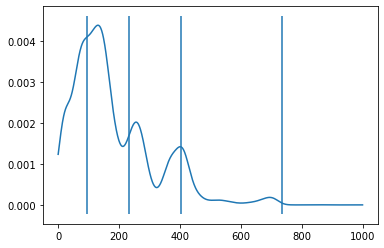

In [1114]:
plt.plot(x, pdf)
ymin, ymax = plt.ylim()
for c in kmeans.cluster_centers_:
    plt.vlines(c, ymin, ymax)

In [1118]:
# vertical position on the page

In [1117]:
x = np.arange(0, 10000)
log_pdf = (kde
 .fit(all_bounding_box_df['y'].values.reshape(-1, 1))
 .score_samples(x.reshape(-1, 1))
)
pdf = np.exp(log_pdf)

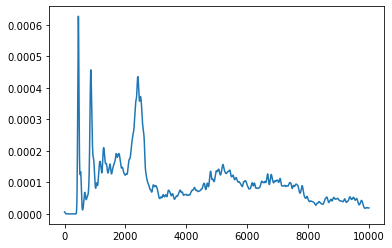

In [1119]:
plt.plot(x, pdf)
ymin, ymax = plt.ylim()

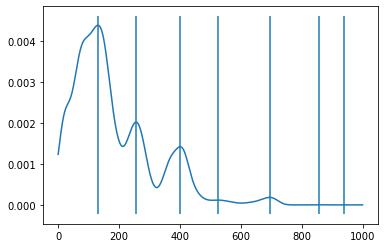

In [858]:
from scipy.signal import argrelextrema

# for local maxima
maxima = argrelextrema(pdf, np.greater)[0]

plt.plot(x, pdf)
ymin, ymax = plt.ylim()
for c in maxima:
    plt.vlines(c, ymin, ymax)

In [ ]:
bounding_box_dfs, all_height_width = await bb.get_bounding_boxes_for_files(
    nyt_files, here=here, headless=True
)

In [911]:
here = os.getcwd()

In [1915]:
page, browser, playwright = await bb.instantiate_new_page_object(headless=False)

In [1916]:
one_file = nyt_files[0]
fp = os.path.join(here, one_file)
file = f'file://{fp}'

await page.goto(file, timeout=0)
# instantiate the model and the weights
model_weights = await bb.async_load_model_files_and_helper_scripts(page)
await page.evaluate(bb.instantiate_model_js % model_weights)
await page.evaluate(bb.get_link_divs_js)
b = await bb.async_get_bounding_box_info(page)

In [ ]:
t = await page.evaluate('''
    a_top_nodes.map(function(d) { 
        var links = Array.from(d.querySelectorAll('a'))
        links
            .map(function(d){return d.href})
            .filter(predictor.get_prediction)
    })
''')

In [1029]:
t = await page.evaluate('''
    a_top_nodes.map(function(d) {return d.getBoundingClientRect()} )
''')

In [1027]:
_ = await page.evaluate('''() => 
    a_top_nodes.map(function(d){
        var binned_height = bin_number_to_array(d.offsetHeight, %s)
        d.style.height = binned_height + 'px'
        d.style.border = '0px',
        d.style.padding = '0px'

})''' % cluster_centers)

In [1030]:
pd.DataFrame(t)['height'].value_counts()

93.171875     62
401.984375    18
232.281250    16
733.453125     2
0.000000       1
Name: height, dtype: int64

In [1026]:
cluster_centers

[401.9951294140076, 93.1819132368389, 232.29484725579087, 733.4667575156927]

In [960]:
await bb.add_visual_bounding_boxes(page)

In [927]:
b = await bb.async_get_bounding_box_info(page)

In [1033]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(all_bounding_box_df[['height']])
kmeans.cluster_centers_
pd.Series(kmeans.predict(all_bounding_box_df[['height']])).value_counts().sort_index()
cluster_centers = kmeans.cluster_centers_.flatten().tolist()

In [1960]:
adjusted_bbs, adjusted_height_width = await bb.get_bounding_boxes_for_files(
    nyt_files[:1000], here=here, article_height_bins=cluster_centers,
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [1178]:
adjusted_coarse_grids = []
for df in tqdm(adjusted_bbs):
    c = bb.get_coarsified_layout_grid(
        df, 
        max_width=df.iloc[0]['page_width'], 
        y_step=.01,
        x_step=.01,
        use_perc=True
    )
    adjusted_coarse_grids.append(c)

  0%|          | 0/150 [00:00<?, ?it/s]

In [1179]:
shapes = list(map(lambda df: df.shape, adjusted_coarse_grids))
miny, minx = pd.DataFrame(shapes).min()
mod_coarse_grids = list(map(lambda df: 
    df.iloc[:miny, :minx]
        .pipe(lambda df: df > 0)
        .astype(int)
, adjusted_coarse_grids))

<AxesSubplot:>

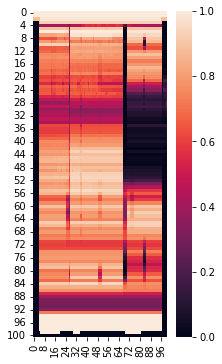

In [1180]:
_, ax = plt.subplots( figsize=(3, 6))
sns.heatmap(
    sum(map(lambda x: x.values, mod_coarse_grids)) / len(mod_coarse_grids), ax=ax
)

<AxesSubplot:>

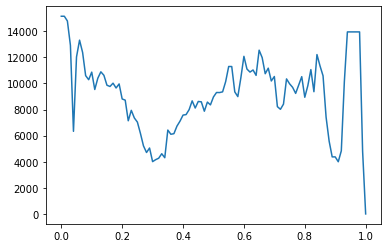

In [1377]:
sum(map(lambda df: df.sum(axis=1), mod_coarse_grids)).plot()

# Get Slot Numbers

In [1196]:
## number of columns

In [1193]:
def consecutive(data, stepsize=0):
    return np.split(data, np.where(np.diff(data) != stepsize)[0] + 1)

([], [])

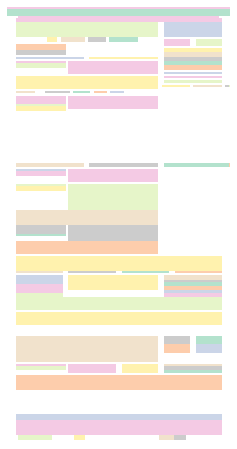

In [1228]:
idx = 4
bb_df = adjusted_bbs[idx].assign(
        site_url=lambda df: df['href'].apply(lambda x: re.sub('https://web.archive.org/web/\d{14}/', '', x))
    )
n = len(value_to_int)
cmap = sns.color_palette("Pastel2", n) 
value_to_int = {j:i for i,j in enumerate(bb_df['site_url'].unique())} # like you did
bb_grid = bb.get_coarsified_layout_grid(adjusted_bbs[idx], fill_with_ones=False, use_perc=True)

_, ax = plt.subplots(figsize=(4, 8))
sns.heatmap(bb_grid.replace(value_to_int), cmap=cmap, ax=ax, cbar=False)
plt.yticks([])
plt.xticks([])

# Plot Two Timesteps

In [1935]:
adjusted_bbs = sorted(adjusted_bbs, key=lambda df: df.iloc[0]['key'])

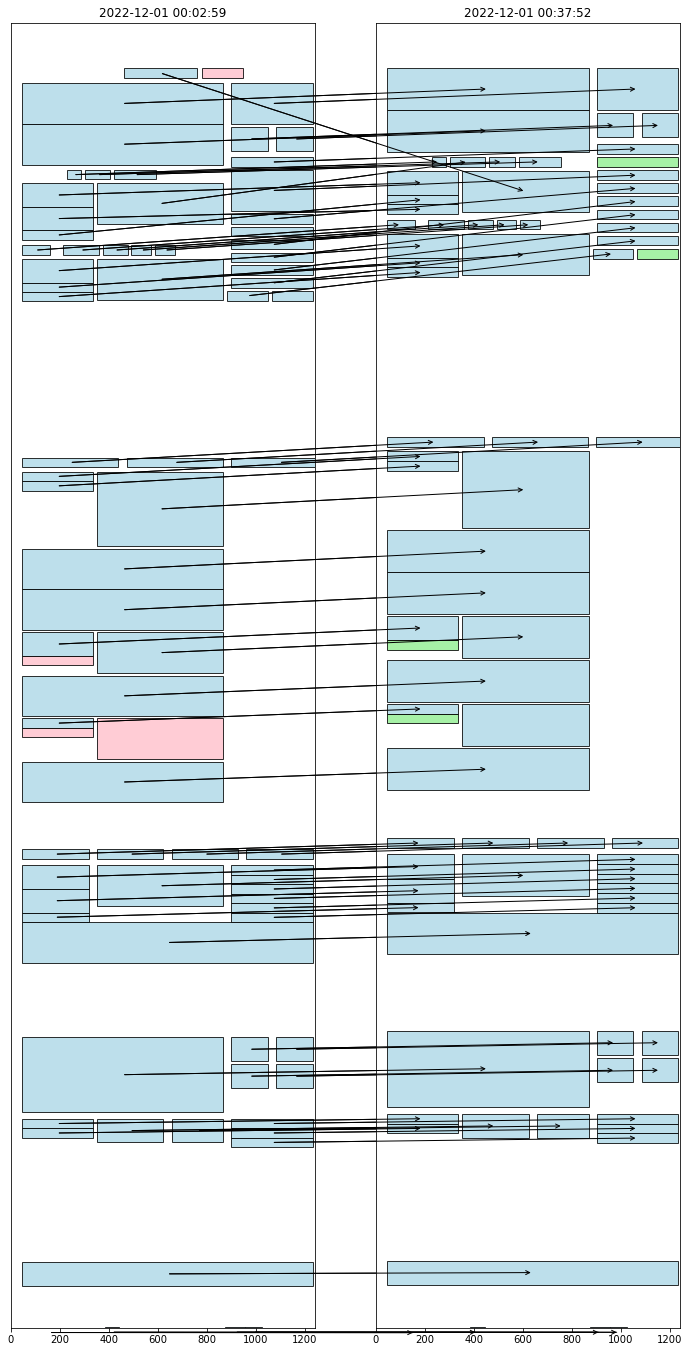

In [1957]:
idx = 0
merged_bb_df, bb_1, bb_2 = bb.merge_and_dedupe_bbs(
    adjusted_bbs[idx], adjusted_bbs[idx + 1]
)

bb.plot_merged_df(merged_bb_df, bb_1=bb_1, bb_2=bb_2)

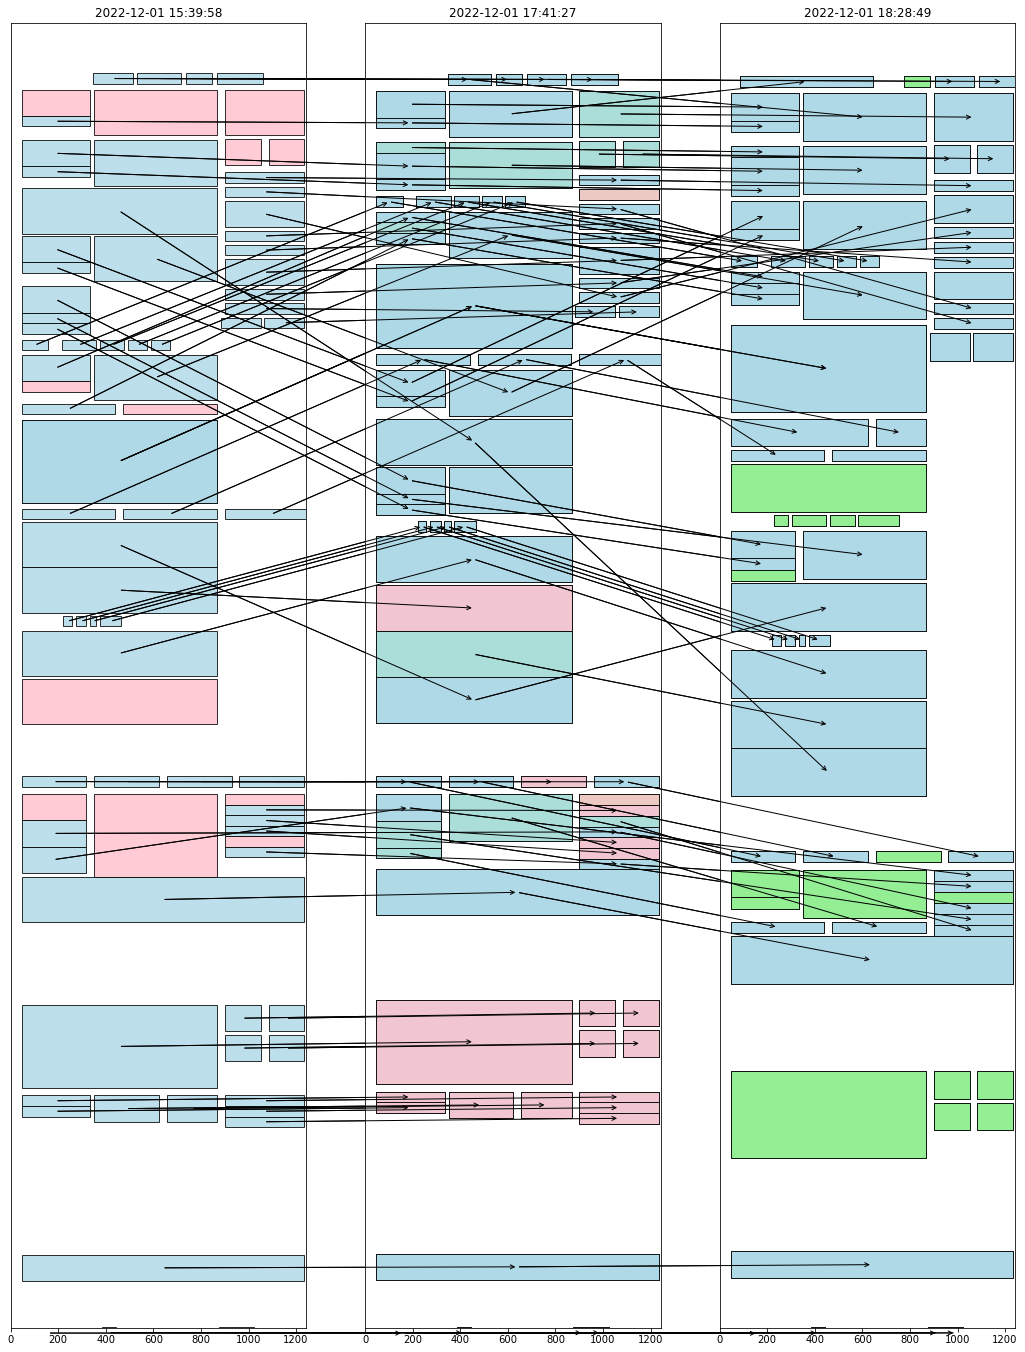

In [1953]:
idx = 23
merged_bb_df, bb_1, bb_2 = bb.merge_and_dedupe_bbs(
    adjusted_bbs[idx], adjusted_bbs[idx + 1]
)

_, axarr = plt.subplots(1, 3, figsize=(18, 24))

bb.plot_merged_df(merged_bb_df, bb_1=bb_1, bb_2=bb_2, axarr=axarr)


merged_bb_df_2, bb_2, bb_3 = bb.merge_and_dedupe_bbs(
    adjusted_bbs[idx + 1], adjusted_bbs[idx + 2]
)
bb.plot_bounding_box_df(bb_3, clip_right=True, ax=axarr[2])
bb.plot_merged_df(
    merged_bb_df_2, bb_1=bb_2, bb_2=bb_3, axarr=[axarr[1], axarr[2]],
    plot_individual=True ## fix
)

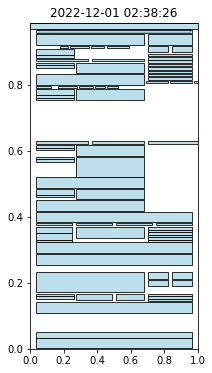

In [1517]:
bb.plot_bounding_box_df(bb_df, use_percs=True, fix_adjacencies=False, figsize=(3,6))

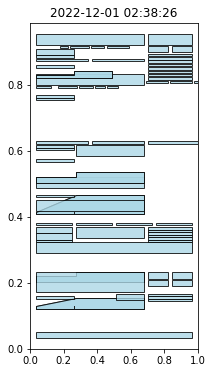

In [1585]:
bb.plot_bounding_box_df(
    bb.restrict_to_wayback_urls_and_process(bb_df), 
    use_percs=True,
    fix_adjacencies=True,
    figsize=(3,6),
    adjancency_tolerance=50
)

In [1612]:
adjacency_idx_mapper

{14: [(17, 'left')],
 17: [(14, 'right')],
 23: [(26, 'left')],
 26: [(23, 'right')],
 31: [(33, 'left')],
 33: [(31, 'right')],
 36: [(38, 'left')],
 38: [(36, 'right')],
 41: [(42, 'right')],
 42: [(41, 'left')],
 85: [(87, 'left')],
 87: [(85, 'right')]}

In [1596]:
a = bb.build_adjacency_index_list(bb.restrict_to_wayback_urls_and_process(bb_df))

In [1583]:
from more_itertools import value_chain, collapse, flatten

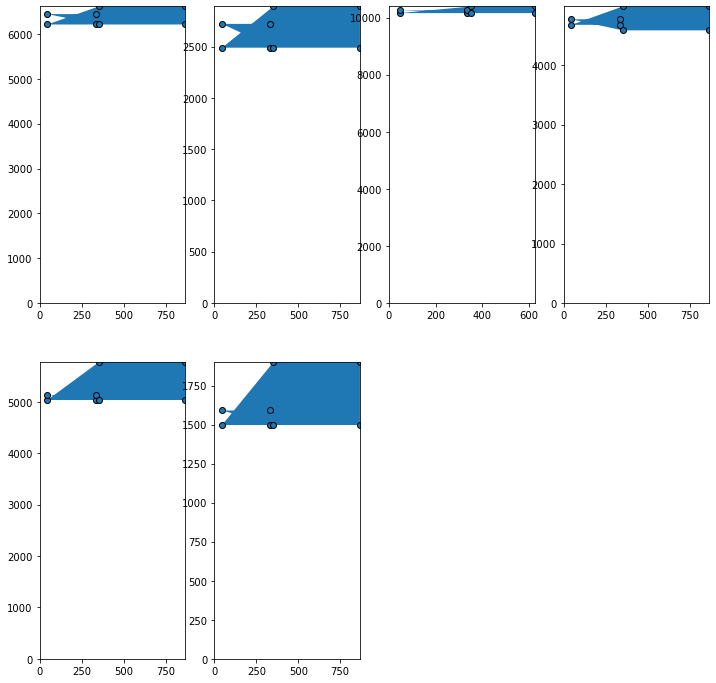

In [1595]:
adjacencies = set(map(lambda x: tuple(sorted(collapse(x))), a.items()))

num_columns = min(4, len(adjacencies))
num_rows = int(len(adjacencies) / num_columns) + 1

_, axarr = plt.subplots(num_rows, num_columns, figsize=(3 * num_columns, 6 * num_rows))
axarr = list(flatten(axarr))

for i, idx_list in enumerate(adjacencies):
    ax = axarr[i]
    borders = bb.get_borders_for_one_adjacency_list(bb_df, list(idx_list), fix_points=True)
    xs = list(map(lambda x: x[0], borders))
    ys = list(map(lambda x: x[1], borders))
    xmax = max(xs)
    ymax = max(ys)
    ax.set_ylim(0, ymax)
    ax.set_xlim(0, xmax)
    patch = Polygon(xy=borders)
    ax.add_patch(patch)
    ax.scatter(xs, ys, edgecolors='black')

for i in range(i+1, num_columns * num_rows):
    axarr[i].remove()

In [1587]:
bb_df.loc[list(idx_list)]

,href,link_text,is_article,x,y,width,height,all_text,page_width,page_height,key,site_url
16,https://web.archive.org/web/20221201023826/htt...,"House Passes Bill to Avert a Rail Strike, Mov...",True,45.914062,1498.367188,288.289062,93.179688,"House Passes Bill to Avert a Rail Strike, Mov...",1280,12363,20221201023826,https://www.nytimes.com/2022/11/30/us/politics...
18,https://web.archive.org/web/20221201023826/htt...,"<img src=""https://web.archive.org/web/2022120...",True,351.203125,1498.367188,516.531250,401.992188,"<img src=""https://web.archive.org/web/2022120...",1280,12363,20221201023826,https://www.nytimes.com/2022/11/30/us/politics...


In [1588]:
borders

[(45.9140625, 1591.546875),
 (45.9140625, 1498.3671875),
 (334.203125, 1498.3671875),
 (334.203125, 1591.546875),
 (334.203125, 1498.3671875),
 (351.203125, 1498.3671875),
 (867.734375, 1498.3671875),
 (867.734375, 1900.359375),
 (351.203125, 1900.359375)]

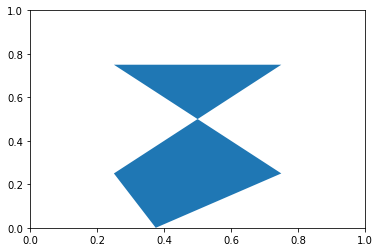

In [1409]:
from matplotlib.patches import Polygon

_, ax = plt.subplots(1, 1)
ax.add_patch(
    Polygon(
        xy=[[.25, .25], [.75, .75], [.25, .75], [.75, .25], [.375, 0] ],
        closed=True,
    )
)

# Plot Upwards Trajectories

In [1181]:
bb.normalize_x_y_height_width(adjusted_bbs[0], round_val=None)

,href,link_text,is_article,x,y,width,height,all_text,page_width,page_height,key,norm_x,norm_y,norm_width,norm_height
0,file:///Users/spangher/Projects/usc-research/n...,Continue reading the main story,True,0.000000,8.000000,1280.000000,232.289062,Continue reading the main story,1280,13000,20221201000259,0.000000,0.000615,1.000000,0.017868
1,file:///Users/spangher/Projects/usc-research/n...,Skip to content,True,156.914062,243.289062,1.000000,93.179688,Skip to content,1280,13000,20221201000259,0.122589,0.018715,0.000781,0.007168
2,file:///Users/spangher/Projects/usc-research/n...,Skip to site index,True,156.914062,243.289062,1.000000,93.179688,Skip to site index,1280,13000,20221201000259,0.122589,0.018715,0.000781,0.007168
3,file:///Users/spangher/Projects/usc-research/n...,,True,0.000000,0.000000,0.000000,0.000000,,1280,13000,20221201000259,0.000000,0.000000,0.000000,0.000000
4,file:///Users/spangher/Projects/usc-research/n...,U.S.,True,60.914062,246.289062,1158.171875,93.179688,U.S. International Canada Español 中文,1280,13000,20221201000259,0.047589,0.018945,0.904822,0.007168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,file:///Users/spangher/Projects/usc-research/n...,Continue reading the main story,True,45.914062,12443.023438,1188.171875,401.992188,Advertisement Continue reading the main story,1280,13000,20221201000259,0.035870,0.957156,0.928259,0.030922
95,https://web.archive.org/web/20221201000259/htt...,© 2022 The New York Times Company,True,63.710938,12858.515625,189.734375,93.179688,© 2022 The New York Times Company,1280,13000,20221201000259,0.049774,0.989117,0.148230,0.007168
96,https://web.archive.org/web/20221201000259/htt...,Accessibility,True,383.921875,12855.015625,59.906250,93.179688,Accessibility,1280,13000,20221201000259,0.299939,0.988847,0.046802,0.007168
97,https://web.archive.org/web/20221201000259/htt...,Terms of Service,True,875.039062,12855.015625,81.914062,93.179688,Terms of Service,1280,13000,20221201000259,0.683624,0.988847,0.063995,0.007168


In [1169]:
all_bounding_box_df = pd.concat(adjusted_bbs)
all_bounding_box_df = (
    all_bounding_box_df
     .loc[lambda df: ~df['href'].str.startswith('file:///')]
     .assign(site_url=lambda df: df['href'].apply(lambda x: re.sub('https://web.archive.org/web/\d{14}/', '', x)))
#      .groupby('site_url')[['x', 'y', 'width', 'height']].aggregate(list)
)

In [1160]:
def transpose_dict(x):
    """
    Convert dict of lists into list of dicts
    """
    cols = list(x.keys())
    output = []
    for p in zip(*[x[c] for c in cols]):
        output.append(dict(zip(cols, p)))
    return output

In [1161]:
frequency_of_urls = all_bounding_box_df['site_url'].value_counts()
likelihood_of_urls = frequency_of_urls / len(bounding_box_dfs)

In [1162]:
min_df = .001
max_df = .8
accepted_urls = likelihood_of_urls.loc[lambda s: (s > min_df) & (s < max_df)]

In [1163]:
article_urls = all_bounding_box_df.loc[lambda df: df['site_url'].isin(accepted_urls.index)]

In [1064]:
article_centric_df = (article_urls
 .groupby('site_url')[['x', 'y', 'width', 'height', 'page_width', 'page_height', 'key']]
 .aggregate(list)
 .apply(dict, axis=1)
 .apply(transpose_dict)
 .apply(lambda x: sorted(x, key=lambda y: y['key']))
)

In [1065]:
a = article_centric_df.iloc[0]

In [1066]:
w = article_urls['page_width'].min()
h = article_urls['page_height'].min()

In [1072]:
newsworthy_shifts = (
    article_centric_df
     # zip of (older, younger) article pairs
     .apply(lambda x: list(zip(x[:-1], x[1:]))) 
     # filter to pairs where the younger article is in a higher position                     
     .apply(lambda x: list(filter(lambda y: y[1]['y'] - y[0]['y'] < -100, x))) 
     # get the position of the younger article                     
     .apply(lambda x: list(map(lambda y: y[1], x))) 
)

In [1073]:
newsworthy_bounding_boxes = pd.DataFrame([x_i for x in newsworthy_shifts.tolist() for x_i in x])

In [1074]:
newsworthy_bounding_boxes['page_width'] = w
newsworthy_bounding_boxes['page_height'] = h

In [1075]:
newsworthy_coarsified_grid = bb.get_coarsified_layout_grid(
    newsworthy_bounding_boxes, max_width=w, max_height=h, show_progress=True
)

  0%|          | 0/1908 [00:00<?, ?it/s]

<AxesSubplot:>

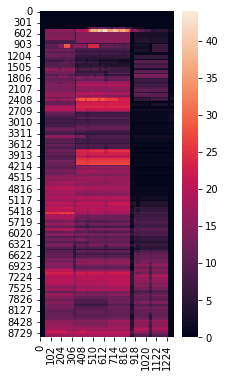

In [1076]:
_, ax = plt.subplots(figsize=(3, 6))
sns.heatmap(newsworthy_coarsified_grid)

In [ ]:
# how many articles start at the top of the page to begin with??

# Lay out the state-space grid

# Examine gold-standard HTMLs for NYTimes

In [72]:
html_file = '../data/gold-html-492893687/cnn.html'

In [86]:
bounding_boxes, page_width_height = await bb.get_bounding_boxes_for_files(
    [html_file], here=os.getcwd(), key_func=key_func
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
reload(bb)

In [100]:
bounding_boxes[0].to_dict(orient='records')

[{'href': 'https://www.cnn.com/europe/live-news/russia-ukraine-war-news-12-29-22/index.html',
  'link_text': ' LIVE UPDATES:  Ukraine',
  'is_article': True,
  'x': 90.0,
  'y': 15.0,
  'width': 173.984375,
  'height': 34.0,
  'all_text': ' LIVE UPDATES:  Ukraine',
  'page_width': 1280,
  'page_height': 7206,
  'key': '492893687'},
 {'href': 'https://www.cnn.com/2022/12/29/politics/george-santos-911-scrutiny/index.html',
  'link_text': ' TRENDING:  George Santos ',
  'is_article': True,
  'x': 263.984375,
  'y': 15.0,
  'width': 201.015625,
  'height': 34.0,
  'all_text': ' TRENDING:  George Santos ',
  'page_width': 1280,
  'page_height': 7206,
  'key': '492893687'},
 {'href': 'https://www.cnn.com/2022/12/29/us/new-york-marijuana-first-legal-sales/index.html',
  'link_text': ' New York marijuana ',
  'is_article': True,
  'x': 465.0,
  'y': 15.0,
  'width': 156.7890625,
  'height': 34.0,
  'all_text': ' New York marijuana ',
  'page_width': 1280,
  'page_height': 7206,
  'key': '49289

In [84]:
key_func = lambda x: re.search('html-(\d+)', x)[1]

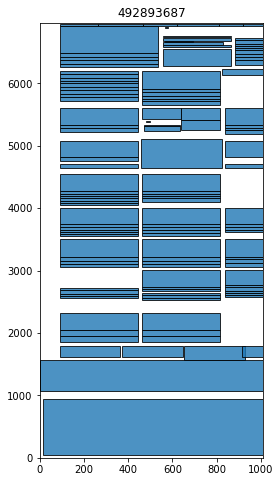

In [97]:
bb.plot_bounding_box_df(bounding_boxes[0], format_title_func=lambda x: x, figsize=(4, 8))

# Slush

In [ ]:
def get_num_intersections(bb_df, pos_col, start):
    size_col = 'width' if pos_col == 'x' else 'height'
    pos_s = bb_df[pos_col]
    pos_e = pos_s + bb_df[size_col]
    return (pos_e > start).sum()

def get_num_intersections_grid(bb_df, pos_col, start, size=None):
    other_col = 'y' if pos_col == 'x' else 'x'
    size_col = 'width' if pos_col == 'x' else 'height'
    

    pos_s = bb_df[pos_col]
    pos_e = pos_s + bb_df[size_col]
#     end = start + size
#     return ((pos_s < start) & (pos_e > start) | (pos_s < end) & (pos_e > end)).sum()
    return (pos_e > start).sum()

def get_clip_size(bb_df, pos_col='x', perc_step_size=.01, perc_intersections_cutoff=.05):
    """
    Calculate the page_width or page_height based on the first column that has more article 
    divs than a threshold (this stops us from having trailing divs throw off our sizing.)
    
    * bb_df: the bounding box DF we wish to reason about
    * pos_col: which column to clip (either `x` or `y`)
    * perc_step_size: 
            how granular we step from outwards in. A smaller `perc_step_size` means
            that we are calculating a more fine-grained stopping point.
    * perc_intersections_cutoff:
            the percentage of articles on the page that need to intersect with the stopping
            point for us to consider stopping.
    
    """
    size_col = 'width' if pos_col == 'x' else 'height'
    curr_max_size = (bb_df[pos_col] + bb_df[size_col]).max()
    pixel_step_size = curr_max_size * perc_step_size
    
    num_articles = len(bb_df)
    
    while True:
        start = curr_max_size - pixel_step_size
        step = pixel_step_size
        num_intersections = get_num_intersections(bb_df, pos_col, start, step)
        if (num_intersections / num_articles) > perc_intersections_cutoff:
            break
        curr_max_size = curr_max_size - pixel_step_size
    return curr_max_size
